In [19]:
%matplotlib inline
import os
from tqdm import tqdm
import sys
import os
file_path = os.getcwd()
project_root =os.path.dirname(file_path)
print(f"Project root: {project_root}")
if project_root not in sys.path:
    sys.path.append(project_root)
    
import time
import jax
from jax import lax
from jax import flatten_util
from Crunch.Models.layers import  *
from Crunch.Models.polynomials import  *
from Crunch.Auxiliary.metrics import  *
from jax import vmap
import jax.numpy as jnp
import jaxopt
import optax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import trange
from jax import jvp, vjp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial
import scipy
from pyDOE import lhs
import scipy.io as sio

import jax
import jax.numpy as jnp
import jaxopt
from jaxopt import LBFGS
import random


Project root: /oscar/data/gk/jdtoscan/References/KKANs/Kurkova-Kolmogorov-Arnold-Newtorks-KKANs


In [20]:
from jax import config
config.update("jax_default_matmul_precision", "float32")

In [21]:
cmap = 'RdBu_r'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

4


In [22]:
import argparse
# Set up argument parser
parser = argparse.ArgumentParser(description='Tuning Parameters')
parser.add_argument('--Equation', type=str, default='SIA', help='Name of equation')
parser.add_argument('--Name', type=str, default='KART_GC2', help='Name of the experiment')
parser.add_argument('--NC', type=int, default=10000, help='Number of samples for training')
parser.add_argument('--NI', type=int, default=512, help='Number of iterations')
parser.add_argument('--NB', type=int, default=512, help='Batch size')
parser.add_argument('--NC_TEST', type=int, default=100, help='Number of test samples')
parser.add_argument('--SEED', type=int, default=444, help='Random seed')
parser.add_argument('--EPOCHS', type=int, default=200000, help='Number of training epochs')
parser.add_argument('--N_LAYERS', type=int, default=4, help='Number of layers in the network')
parser.add_argument('--HIDDEN', type=int, default=32, help='Number of hidden units per layer')
parser.add_argument('--FEATURES', type=int, default=64, help='Feature size')
parser.add_argument('--degree', type=int, default=15, help='Degree of outer')
parser.add_argument('--degree_T', type=int, default=15, help='Degree of polynomial')
parser.add_argument('--lr_fact', type=float, default=0.2, help='Scale Lr')
parser.add_argument('--eta', type=float, default=0.01, help='Learning rate or step size for adaptive gamma')
parser.add_argument('--gamma', type=float, default=0.999, help='Decay rate for adaptive gamma')
parser.add_argument('--gamma_grads', type=float, default=0.99, help='Decay rate for adaptive gamma')
parser.add_argument('--alpha', type=float, default=0.999750, help='Decay rate for exponential moving average')
parser.add_argument('--cap_RBA', type=float, default=20, help='Cap limit for RBA')
parser.add_argument('--max_RBA', type=float, help='Maximum RBA value, default calculated as eta / (1 - gamma)')
parser.add_argument('--decay_rate', type=float, default=0.9, help='Decay rate for learning rate schedule')
parser.add_argument('--LR', type=float, default=1e-3, help='Initial learning rate')
parser.add_argument('--decay_step', type=int,default=5000, help='Decay step size')
parser.add_argument('--Note', type=str, default='', help='In case')
parser.add_argument('--basis', type=str, default='rbf', help='basis selection for g')


# Parse arguments and display them
args, unknown = parser.parse_known_args()
for arg, value in vars(args).items():
    print(f'{arg}: {value}')

# Initialize parameters with parsed or default values
NC = args.NC
NI = args.NI
NB = args.NB
NC_TEST = args.NC_TEST
SEED = args.SEED
EPOCHS = args.EPOCHS
N_LAYERS = args.N_LAYERS
HIDDEN = args.HIDDEN
FEATURES = args.FEATURES
degree = args.degree
degree_T = args.degree_T
eta = args.eta
#RBA Params
gamma = args.gamma
alpha = args.alpha
max_RBA0 = args.max_RBA if args.max_RBA is not None else eta / (1 - gamma)
cap_RBA = args.cap_RBA
# Global weights
gamma_grads=args.gamma_grads
# Optimizer parameters
decay_rate = args.decay_rate
LR = args.LR
lr0 = LR
decay_step = args.decay_step# if args.decay_step is not None else int(EPOCHS * jnp.log(decay_rate) / jnp.log(lrf / lr0))
args.Name=args.Name+f'g:{args.basis}-[d:{degree},lr:{args.lr_fact}]_psi[N:{N_LAYERS},H:{HIDDEN},T:{degree_T},F:{FEATURES},lr:{lr0:.1e},rate:{decay_rate},step:{decay_step}]_RBA[{max_RBA0:.2f}-{cap_RBA:.2f}]__GW:[{alpha:.6f},{args.gamma_grads:.4f}]_Seed:{SEED}'+args.Note
print(args.Name)
# random key
key = jax.random.PRNGKey(SEED)
key, subkey = jax.random.split(key, 2)
# Initialize NumPy seed
np.random.seed(SEED)
# Initialize Python's random module seed
random.seed(SEED)


Equation: SIA
Name: KART_GC2
NC: 10000
NI: 512
NB: 512
NC_TEST: 100
SEED: 444
EPOCHS: 200000
N_LAYERS: 4
HIDDEN: 32
FEATURES: 64
degree: 15
degree_T: 15
lr_fact: 0.2
eta: 0.01
gamma: 0.999
gamma_grads: 0.99
alpha: 0.99975
cap_RBA: 20
max_RBA: None
decay_rate: 0.9
LR: 0.001
decay_step: 5000
Note: 
basis: rbf
KART_GC2g:rbf-[d:15,lr:0.2]_psi[N:4,H:32,T:15,F:64,lr:1.0e-03,rate:0.9,step:5000]_RBA[10.00-20.00]__GW:[0.999750,0.9900]_Seed:444


In [23]:
from tensorboardX import  SummaryWriter
args.Name =project_root+'/Results/'+args.Equation+'/'+args.Name+'/'
log_dir =args.Name  # specify the directory where logs will be saved
writer = SummaryWriter(log_dir)
print(log_dir)

/oscar/data/gk/jdtoscan/References/KKANs/Kurkova-Kolmogorov-Arnold-Newtorks-KKANs/Results/SIA/KART_GC2g:rbf-[d:15,lr:0.2]_psi[N:4,H:32,T:15,F:64,lr:1.0e-03,rate:0.9,step:5000]_RBA[10.00-20.00]__GW:[0.999750,0.9900]_Seed:444/


## 1. PINN

In [24]:
class get_Psi(nn.Module):
    degree: int
    features: Sequence[int]
    M: int = 10

    def setup(self):
        # Set up the Chebyshev functions (T_funcs) based on the degree
        self.T_funcs = [globals()[f"T{i}"] for i in range(self.degree + 1)]
    @nn.compact
    def __call__(self, inputs):
        init = nn.initializers.glorot_normal()
        sum_psi = 0
        for i, X in enumerate(inputs):
            H = Polynomial_Embedding_Layer(degree=self.degree)(X) 
            for fs in self.features[:-1]:
                H = nn.activation.tanh(nn.Dense(fs)(H))
            H = Polynomial_Embedding_Layer(degree=self.degree)(H)
            H = nn.Dense(self.features[-1])(H)
            sum_psi += H
        return sum_psi


# The PINN class integrates GetPhi and RBF_KAN_layer to compute the final output
class PINN(nn.Module):
    degree: int
    degree_T: int
    features: Sequence[int]
    M: int = 10
    basis: str= 'rbf'
    out_dim: int =1
    def setup(self):
        # Initialize the GetPhi submodule
        self.get_Psi = get_Psi(degree=self.degree_T, features=self.features, M=self.M)
        if self.basis.lower()=='rbf':
            self.g_fx= RBF_KAN_layer(out_dim=self.out_dim, degree=self.degree)
        elif self.basis.lower()=='chebyshev':
            self.g_fx= Polynomial_KAN_layer(out_dim=self.out_dim, degree=self.degree)
        elif self.basis.lower()=='legendre':
            self.g_fx= Polynomial_KAN_layer(out_dim=self.out_dim, degree=self.degree,polynomial_type='L')
        elif self.basis.lower()=='sin_series':
            self.g_fx= AcNet_KAN_layer(out_dim=self.out_dim, degree=self.degree)
        elif self.basis.lower()=='chebyshev_grid':
            self.g_fx= Polynomial_grid_KAN_layer(out_dim=self.out_dim, degree=self.degree,polynomial_type='T')
        elif self.basis.lower()=='rbf_single':
            self.g_fx= RBF_KAN_single_layer(out_dim=self.out_dim, degree=self.degree)
        else:
            print(f'the desired basis:{self.basis.lower()} is not available.')
    @nn.compact
    def __call__(self, t, x):
        # Process inputs through the GetPhi function
        inputs = [t, x]
        sum_psi = self.get_Psi(inputs)
        sum_Phi = self.g_fx(sum_psi)
        return sum_Phi


In [25]:
@partial(jax.jit, static_argnums=(0, 1))  # key and optimizer are static
def update_model(key, optimizer, gradient, params, state):
    # Perform updates using the specified optimizer and key
    updates, new_state = optimizer.update(gradient['params'][key], state)
    new_params = optax.apply_updates(params['params'][key], updates)
    # Return updated parameters and state for this key only
    params['params'][key] = new_params
    return params, new_state


In [26]:
@partial(jax.jit, static_argnums=(0,))
def apply_model(apply_fn, params, lambdas, gamma, eta,lamE,lamB,all_grads,alpha, *train_data):
    # Unpack data
    def data_loss(params, t1, x1, u1,t2, x2, u2,lambdas):
        return 10*jnp.mean(lambdas*(apply_fn(params, t1, x1) - u1)**2)+jnp.mean((apply_fn(params, t2, x2) - u2)**2)
    # unpack data
    t1, x1, u1,t2, x2, u2 = train_data
    #Update RBA
    r_1=jnp.abs((apply_fn(params, t1, x1) - u1))
    new_lambdas=gamma*lambdas+eta*(r_1/r_1.max())
    #Function
    loss_fn = lambda params: data_loss(params, t1,x1,u1,t2, x2, u2,new_lambdas)
    loss, total_gradient = jax.value_and_grad(loss_fn)(params)

    #Store
    all_loss={
        'loss_data':loss,
        'loss_BCs':0.0,
        'Loss':loss,
    }
    all_grads={
        'grad_bar_PDE':0.0,
        'grad_bar_BCs':0.0,
        'grad_PDE':0.0,
        'grad_BCs':0.0,
    }
    return all_loss, total_gradient, new_lambdas,lamB,all_grads

In [27]:
def get_gamma(eta, max_RBA):
    gamma_it = 1-eta/max_RBA
    return gamma_it

# Generate Data

In [28]:
data_1_path='/users/jdtoscan/data/jdtoscan/PIML/Crunch_PIML/Data/Sia/all_ito_in.npy'
data_2_path='/users/jdtoscan/data/jdtoscan/PIML/Crunch_PIML/Data/Sia/all_ito_out.npy'
loaded_data_1=np.load(data_1_path,allow_pickle=False)
loaded_data_2=np.load(data_2_path,allow_pickle=False)

loaded_data_1.shape
loaded_data_2.shape

(93880, 4)

In [29]:
# Flatten the full grid for testing data
t1 = loaded_data_1[:,0:1]
x1 = loaded_data_1[:,1:2]
# Flatten the full grid for testing data
t2 = loaded_data_2[:,0:1]
x2 = loaded_data_2[:,1:2]
# Data
u1=loaded_data_1[:,3:4]
u2=loaded_data_2[:,3:4]
# Evaluate ground truth at all grid points (testing data)
t_gt=np.vstack((t1,t2))
x_gt=np.vstack((x1,x2))
u_gt = np.vstack((u1,u2))


# Collocation points (training data) using LHS
lb = jnp.array([t_gt.min(), x_gt.min()])
ub = jnp.array([t_gt.max(), x_gt.max()])
X_c = lb + (ub - lb)*lhs(2, NC)
tc = X_c[:, 0:1]
xc = X_c[:, 1:2]

# Evaluate ground truth at training points
u_train = u1


# Create the training and testing datasets
train_data = (t1, x1, u1,t2, x2, u2)
lambdas = u_train * 0   # same size as training outputs
test_data = t_gt, x_gt, u_gt

In [30]:
print(u2.shape,t2.shape)

(93880, 1) (93880, 1)


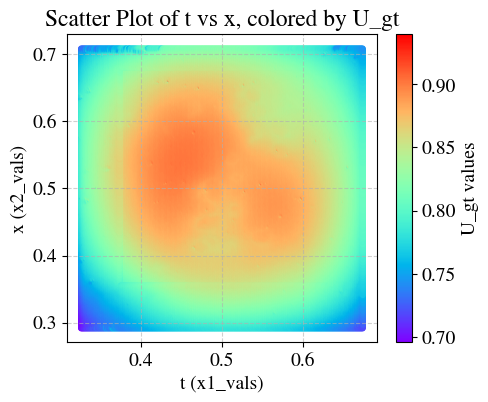

In [31]:
# Extract data (as in your provided snippet)
x1_vals = loaded_data_1[:, 0:1]
x2_vals = loaded_data_1[:, 1:2]
U_gt = loaded_data_1[:, 3:4]

# Assign t and x
t = x1_vals
x = x2_vals

# Create the scatter plot
plt.figure(figsize=(5, 4)) # Optional: Adjust figure size
scatter = plt.scatter(t_gt, x_gt, c=u_gt, cmap='rainbow', s=10) # s controls point size

# Add a colorbar to show the mapping of colors to U_gt values
cbar = plt.colorbar(scatter)
cbar.set_label('U_gt values')

# Add labels and title for clarity
plt.xlabel('t (x1_vals)')
plt.ylabel('x (x2_vals)')
plt.title('Scatter Plot of t vs x, colored by U_gt')

# Show the plot
plt.grid(True, linestyle='--', alpha=0.6) # Optional: Add grid
plt.show()

In [32]:
u_gt.shape

(221880, 1)

In [33]:
# Batches SNR
n_batches=256
X_all=jnp.hstack([t1, x1, u1])
X_batches=np.array(np.split(X_all,n_batches))
X_batches.shape


(256, 500, 3)

## Initialize Model

In [34]:

# force jax to use one device
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

# feature sizes
feat_sizes = tuple([HIDDEN for _ in range(N_LAYERS)] + [FEATURES])
print(feat_sizes)
# make & init model
model = PINN(degree,degree_T,feat_sizes,basis=args.basis)
params = model.init(subkey, jnp.ones((NC, 1)), jnp.ones((NC, 1)))

optimizers = {}
for key in params['params'].keys():
    if key=='g_fx':
        print(f'Kart model with basis:{args.basis}')
        optimizers[key]=optax.adam(optax.exponential_decay(lr0*args.lr_fact, decay_step, decay_rate, staircase=False))
    else:
        optimizers[key]=optax.adam(optax.exponential_decay(lr0, decay_step, decay_rate, staircase=False))

# Initialize optimizer states for each parameter group
states = {key: optim.init(params['params'][key]) for key, optim in optimizers.items()}

# forward & loss function
apply_fn = jax.jit(model.apply)


total_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(total_params )

(32, 32, 32, 32, 64)
Kart model with basis:rbf
74127


In [ ]:
all_errors = []
all_its = []
all_loss = []
all_gamma = []
all_lamB = []
all_max_RBA = []
all_SNR_psi = []
all_SNR_g = []
all_lamE = []
all_lambdas=[]
all_gc = []

start = time.time()
pbar = tqdm(range(1, EPOCHS + 1), desc='Training Progress')
gamma_it=get_gamma(eta, max_RBA0)
#Global weights
max_RBA=max_RBA0
lamE,lamB=1,max_RBA**2
#RBA
step_RBA=(cap_RBA-max_RBA0)/((EPOCHS)/50000-1)
# initialize grads container
all_grads={
    'grad_bar_PDE':1,
    'grad_bar_BCs':1,
}
for e in pbar:
    # single run
    all_loss_it, gradient, lambdas,lamB,all_grads = apply_model(apply_fn, params, lambdas,gamma_it,eta,lamE,lamB,all_grads,alpha, *train_data)
    for key in params['params']:
        params, states[key] = update_model(key, optimizers[key], gradient, params, states[key])
    log_frequency = 1000#1 if e < 500 else 100 if e <= 5000 else 500
    if e % log_frequency == 0:
        # Update RBA
        max_RBA=max_RBA0+step_RBA*e//50000
        if max_RBA>cap_RBA+1:
            max_RBA=cap_RBA+1
            alpha=1
        gamma_it=get_gamma(eta, max_RBA)
        all_lambdas.append(np.array(lambdas))  # JAX to NumPy conversion
        #Compute errors
        error = relative_l2(apply_fn(params, t_gt, x_gt), u_gt)
        # Updating the tqdm progress bar with loss and other metrics
        pbar.set_description(f"It: {e}/{EPOCHS} | Error: {error:.3e} | lam_max: {lambdas.max():.3f}| max_RBA: {max_RBA:.3f}| lamB: {lamB:.3f}|")
        # Log metrics to TensorBoard
        writer.add_scalar('Error', error, global_step=e)
        writer.add_scalar('lam_max', lambdas.max(), global_step=e)
        writer.add_scalar('max_RBA', max_RBA, global_step=e)
        writer.add_scalar('lamB', lamB, global_step=e)
        writer.add_scalar('gamma_it', gamma_it, global_step=e)


        for key, value in all_loss_it.items():
            writer.add_scalar(key, value, global_step=e)

        for key, value in all_grads.items():
            writer.add_scalar(key, value, global_step=e)
                # Append metrics to lists
        all_errors.append(error)
        all_its.append(e)
        all_lambdas.append(np.array(lambdas))
        all_loss.append(all_loss_it['Loss'])
        all_gamma.append(gamma_it)
        all_lamB.append(lamB)
        all_max_RBA.append(max_RBA)
        all_lamE.append(lamE)
end = time.time()
print(f'Runtime: {((end - start) / EPOCHS * 1000):.2f} ms/iter.')

# Save Results

In [21]:
results_dict = {
    'model_name': args.Name,
    'all_errors': all_errors,
    'all_its': all_its,
    'all_loss': all_loss,
    'all_gamma': all_gamma,
    'all_lamB': all_lamB,
    'all_max_RBA': all_max_RBA,
    'all_gc': all_gc,
}

# Save dictionary as a .mat file
scipy.io.savemat(args.Name + 'Log_files.mat', results_dict)

# Errors


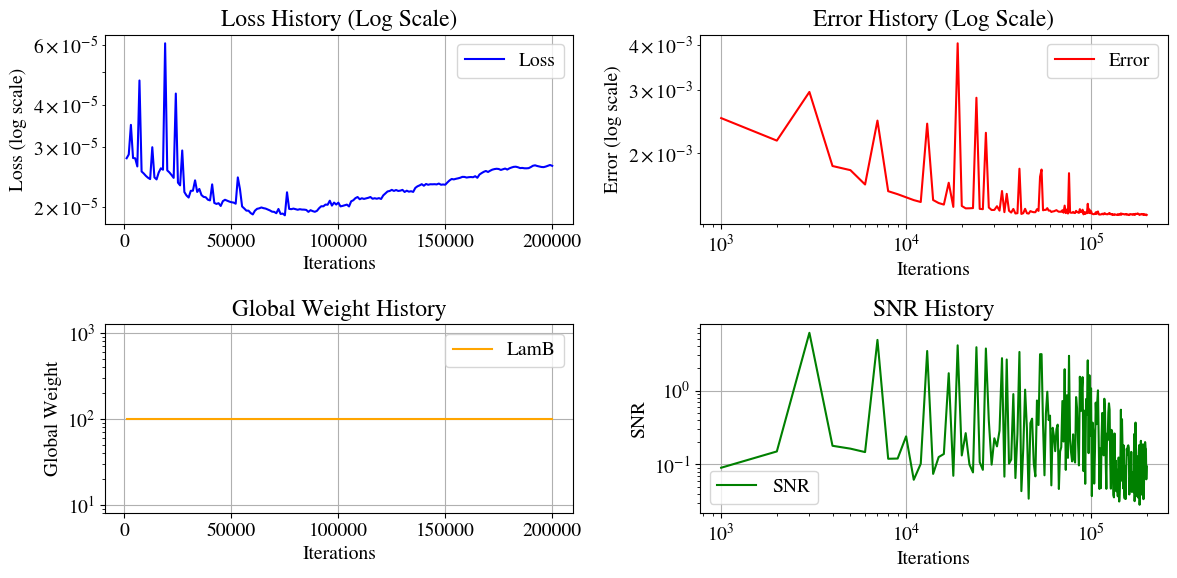

In [22]:
# Adjusting the plot to use a log scale for both loss and error

plt.figure(figsize=(12, 6))

# Plotting loss history with log scale
plt.subplot(2, 2, 1)
plt.plot(all_its, all_loss, label='Loss', color='blue')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss (log scale)')
plt.title('Loss History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 2)
plt.plot(all_its, all_errors, label='Error', color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Error (log scale)')
plt.title('Error History (Log Scale)')
plt.grid(True)
plt.legend()

# Plotting error history with log scale
plt.subplot(2, 2, 3)
plt.plot(all_its, all_lamB, label='LamB', color='orange')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Global Weight')
plt.title('Global Weight History')
plt.grid(True)
plt.legend()



# Show the plots
plt.tight_layout()
plt.savefig(args.Name+'_Loss.png')
plt.show()


In [23]:
error = relative_l2(apply_fn(params, t_gt, x_gt), u_gt)
print(f'RL2 error: {error:.8f}') 

RL2 error: 0.00134893


Plotting scattered data points...


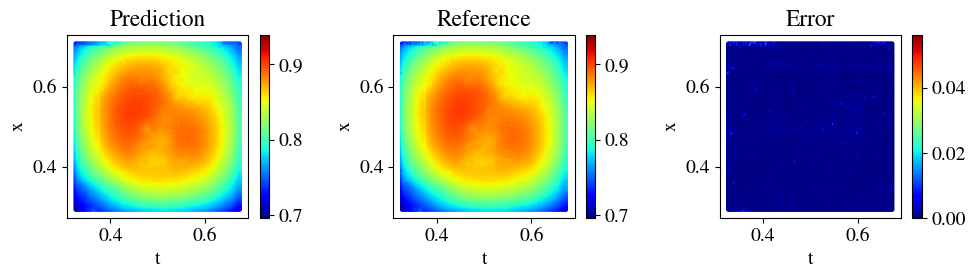

In [24]:
# Choose ONE set of points (e.g., testing points) for a consistent plot:
t_plot = t_gt # Using testing points as an example
x_plot = x_gt

u_plot = apply_fn(params, t_plot, x_plot).flatten() # Ensure u_plot is 1D
Exact0_plot = u_gt.flatten() # Ensure Exact0_plot is 1D

print('Plotting scattered data points...')

# --- Plotting code ---
fig = plt.figure(figsize=(10, 3))

# Determine consistent color limits for Prediction and Reference plots
vmin_val = min(np.min(Exact0_plot), np.min(u_plot))
vmax_val = max(np.max(Exact0_plot), np.max(u_plot))

# Scatter plot for Prediction
ax1 = fig.add_subplot(131)
# Use the 1D arrays directly
scatter1 = ax1.scatter(t_plot, x_plot, c=u_plot, cmap='jet', s=1, vmin=vmin_val, vmax=vmax_val)
fig.colorbar(scatter1, ax=ax1)
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction')

# Scatter plot for Exact solution (Reference)
ax2 = fig.add_subplot(132)
# Use the 1D arrays directly
scatter2 = ax2.scatter(t_plot, x_plot, c=Exact0_plot, cmap='jet', s=1, vmin=vmin_val, vmax=vmax_val)
fig.colorbar(scatter2, ax=ax2)
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Reference')

# Scatter plot for Error
ax3 = fig.add_subplot(133)
error_plot = np.abs(Exact0_plot - u_plot)
# Use the 1D arrays directly
scatter3 = ax3.scatter(t_plot, x_plot, c=error_plot, cmap='jet', s=1) # Error scale might differ
fig.colorbar(scatter3, ax=ax3)
ax3.set_xlabel('t')
ax3.set_ylabel('x')
ax3.set_title('Error')

plt.tight_layout()
# Make sure args.Name is defined
# plt.savefig(args.Name + '_Results_Scatter.png')
plt.show()

In [25]:
# Compute derivatives
v_t = jnp.ones_like(t_plot) # Tangent vector for t direction
v_x = jnp.ones_like(x_plot) # Tangent vector for x direction

# Compute du/dt at points (t_plot, x_plot)
_, ut = jax.jvp(lambda t_val: apply_fn(params, t_val, x_plot), (t_plot,), (v_t,))

# Compute du/dx at points (t_plot, x_plot)
_, ux = jax.jvp(lambda x_val: apply_fn(params, t_plot, x_val), (x_plot,), (v_x,))

# Flatten results for plotting consistency
ut_plot = ut.flatten()
ux_plot = ux.flatten()



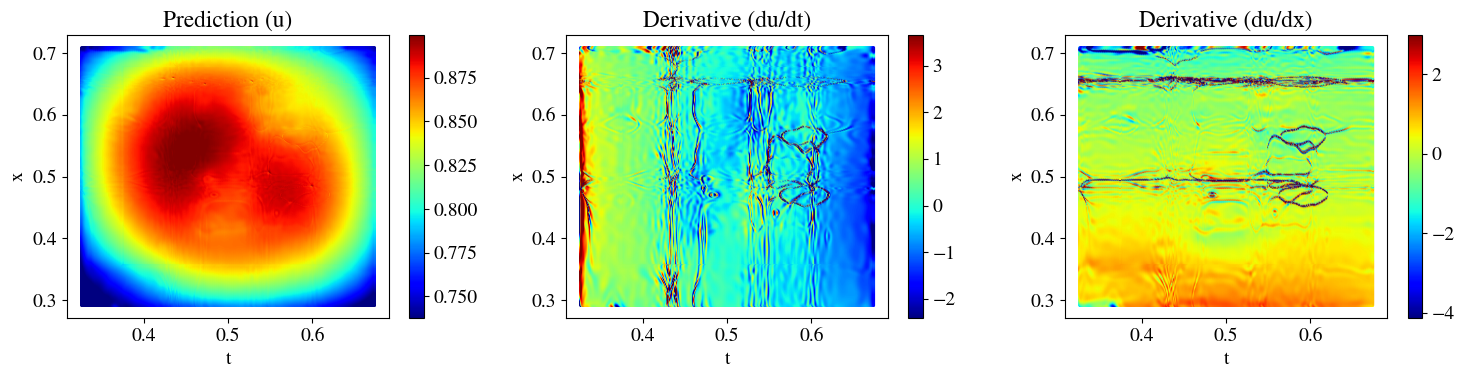

In [27]:
fig = plt.figure(figsize=(15, 4))

# --- Scatter plot for Prediction (u) ---
ax1 = fig.add_subplot(131)
# Determine color limits for the prediction plot
vmin_u = np.percentile(u_plot, 1) # Use percentiles for robustness
vmax_u = np.percentile(u_plot, 99)
scatter1 = ax1.scatter(t_plot, x_plot, c=u_plot, cmap='jet', s=1, vmin=vmin_u, vmax=vmax_u)
fig.colorbar(scatter1, ax=ax1)
ax1.set_xlabel('t')
ax1.set_ylabel('x')
ax1.set_title('Prediction (u)')

# --- Scatter plot for Derivative w.r.t. t (ut) ---
ax2 = fig.add_subplot(132)
# Determine color limits for the du/dt plot
vmin_ut = np.percentile(ut_plot, 1) # Use percentiles for robustness
vmax_ut = np.percentile(ut_plot, 99)
scatter2 = ax2.scatter(t_plot, x_plot, c=ut_plot, cmap='jet', s=1, vmin=vmin_ut, vmax=vmax_ut)
fig.colorbar(scatter2, ax=ax2)
ax2.set_xlabel('t')
ax2.set_ylabel('x')
ax2.set_title('Derivative (du/dt)')

# --- Scatter plot for Derivative w.r.t. x (ux) ---
ax3 = fig.add_subplot(133)
# Determine color limits for the du/dx plot
vmin_ux = np.percentile(ux_plot, 1) # Use percentiles for robustness
vmax_ux = np.percentile(ux_plot, 99)
scatter3 = ax3.scatter(t_plot, x_plot, c=ux_plot, cmap='jet', s=1, vmin=vmin_ux, vmax=vmax_ux)
fig.colorbar(scatter3, ax=ax3)
ax3.set_xlabel('t')
ax3.set_ylabel('x')
ax3.set_title('Derivative (du/dx)')

plt.tight_layout()

plt.show()